In [97]:
import pandas as pd

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing

In [77]:
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [78]:
u_priceData = priceData.copy()
# iterate through the rainfallData and add the rainfall to the priceData
for index, row in rainfallData.iterrows():
    # match the year and month from the rainfall data to the pricedata
    year = row['year']
    month = row['month']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'anuradhapura'] = row['anuradhapura']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'jaffna'] = row['jaffna']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']

In [79]:
df = u_priceData.copy()
def preprocess_input(df):
    df = df.copy()

    # Drop rows with missing values if any
    df.dropna(inplace=True)

    # Split df into X and y
    X = df.drop("Price", axis=1)
    Y = df["Price"]

    return X, Y
X, Y = preprocess_input(df)

In [93]:
# Preprocessing pipeline
numeric_features = ['Week', 'Month', 'Year',
                    #  'anuradhapura', 'jaffna', 'nuwaraeliya'
                     ]
categorical_features = ['Name', 'Season']

numeric_transformer = Pipeline(steps=[
    ('num', 'passthrough')])  # No transformation needed for numeric features

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', RandomForestRegressor())])

In [ ]:
regression_model.fit(X, Y)
accuracy = regression_model.score(X, Y)
print("Accuracy:", accuracy*100)

In [ ]:
def get_user_input():
    name = input("Enter the name of the item: ")
    week = int(input("Enter the week: "))
    month = int(input("Enter the month: "))
    year = int(input("Enter the year: "))
    if month in range(3, 5):
        season = "First Inter-monsoon Season"
    elif month in range(5, 10):
        season = "South-West Monsoon Season"
    elif month in range(10, 12):
        season = "Second Inter-monsoon Season"
    else:
        season = "North-East Monsoon Season"
    anuradhapura = float(input("Enter the rainfall in Anuradhapura: "))
    jaffna = float(input("Enter the rainfall in Jaffna: "))
    nuwaraeliya = float(input("Enter the rainfall in Nuwara Eliya: "))
    return {"Name": name, 'Week': week, 'Month': month, 'Year': year, 'Season': season, 'anuradhapura': anuradhapura, 'jaffna': jaffna, 'nuwaraeliya': nuwaraeliya}


In [ ]:
user_data = get_user_input()
user_df = pd.DataFrame([user_data])
predicted_price = regression_model.predict(user_df)

# Display prediction
print("Predicted price:", predicted_price[0])

In [ ]:
data2 = df.copy()
data2.dropna()
sns.boxplot(data2["Price"])

In [ ]:
sns.relplot(data=data2, x="Name", y="Price", hue="Season", kind="line")

In [ ]:
dist = data2["Name"]
distset = set(dist)
dd = list(distset)
dictOfWords = { dd[i] : i for i in range(0, len(dd) ) }
data2["Name"] = data2["Name"].map(dictOfWords)

dist = (data2["Season"])
distset = set(dist)
dd = list(distset)
dictOfWords = { dd[i] : i for i in range(0, len(dd) ) }
data2["Season"] = data2["Season"].map(dictOfWords)

plt.title('Correlation Heatmap')
dataplot = sns.heatmap(data2.corr(), cmap="YlGnBu", annot=True)

plt.show()

# Test

In [5]:
import numpy as np

In [81]:
data2 = df.copy()
data2 = data2.dropna()

In [82]:
data2.shape

(18511, 6)

In [83]:
data2["Price"]

0        135.15
1        111.11
2        112.86
3         99.39
4        228.57
          ...  
19715    246.25
19716    292.61
19717    462.17
19718    255.91
19719    641.50
Name: Price, Length: 18511, dtype: float64

In [84]:
# IQR
Q1 = np.percentile(data2["Price"], 25, interpolation = 'midpoint')
Q3 = np.percentile(data2["Price"], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

In [85]:
# Upper bound
upper = np.where(data2["Price"] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(data2["Price"] <= (Q1-1.5*IQR))
print(upper[0], lower[0])

[   17   201   257 ... 18494 18496 18510] []


In [86]:
data2.reset_index(inplace=True, drop=True)

# Removing the outliers
data2.drop(upper[0], inplace=True)
data2.drop(lower[0], inplace=True)

print("New Shape: ", data2.shape)

New Shape:  (17344, 6)


<Axes: title={'center': 'Box plot after outlier removal'}, ylabel='Price'>

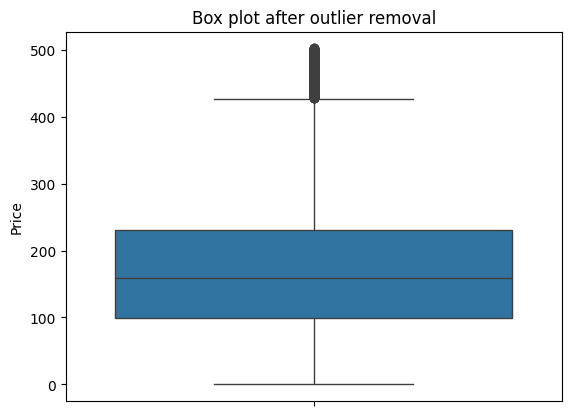

In [14]:
plt.title("Box plot after outlier removal")
sns.boxplot(data2["Price"])

<Axes: title={'center': 'Price Distribution'}, xlabel='Price', ylabel='Count'>

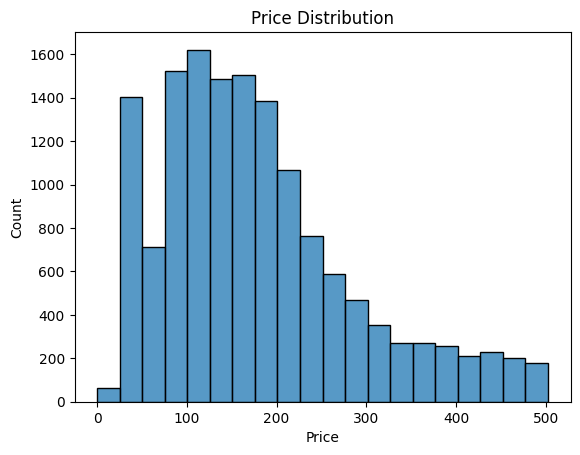

In [15]:
plt.title('Price Distribution')
sns.histplot(data=data2, x="Price", bins=20)

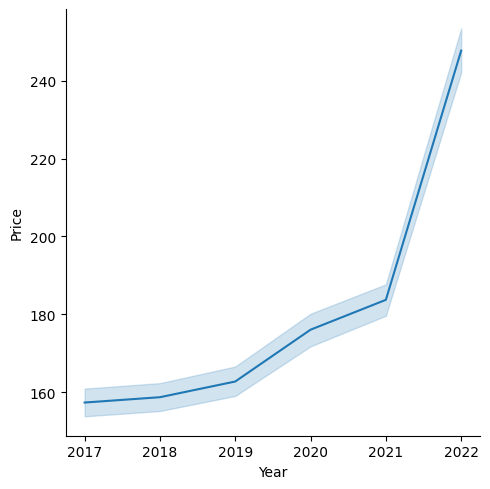

In [16]:
# Line plot of Price over Years
sns.relplot(data=data2, x="Year", y="Price", kind="line")

In [88]:
def preprocess_input(df):
    df = df.copy()

    # Drop rows with missing values if any
    df.dropna(inplace=True)

    # Split df into X and y
    X = df.drop("Price", axis=1)
    Y = df["Price"]

    # Train-test split
    X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, shuffle=True)

    return X_train, X_test, Y_train, Y_test

In [89]:
df = data2.copy()


X_train, X_test, Y_train, Y_test = preprocess_input(df)

<Axes: title={'center': 'Price Fluxuation of Carrot in Sri Lanka'}>

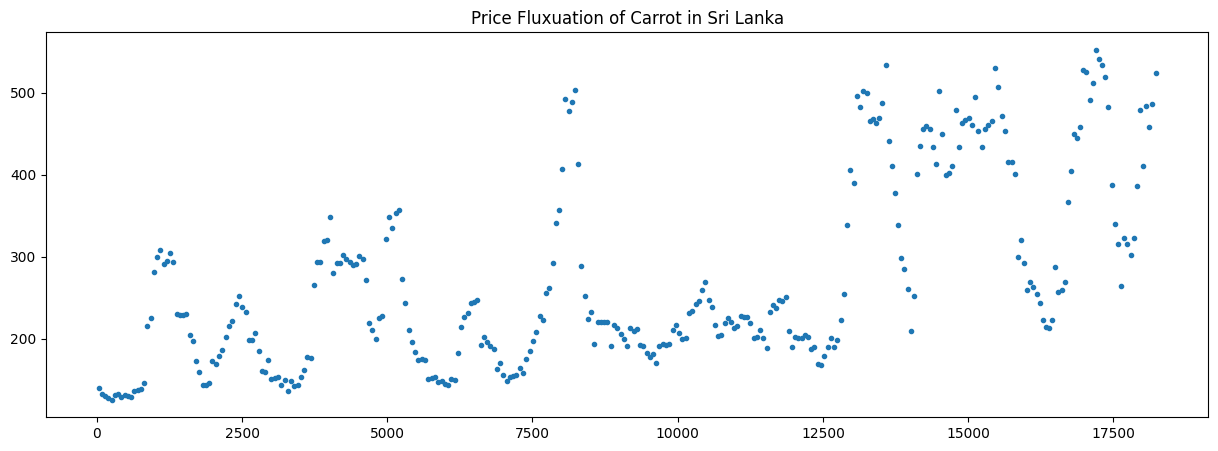

In [90]:
df[df["Name"] == "Carrot_UPCVEG_1kg"]["Price"].plot(style='.',figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")

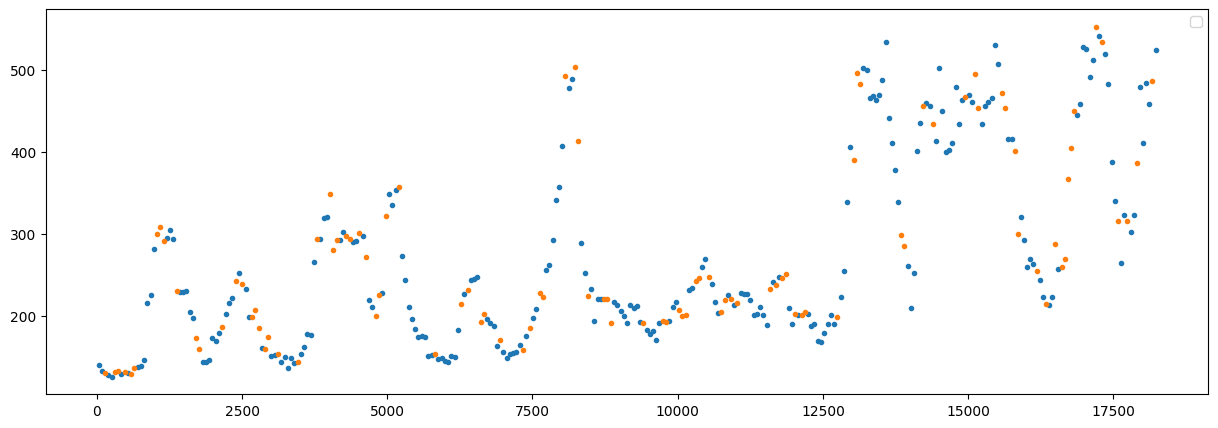

In [91]:
train = X_train.merge(Y_train, left_index=True, right_index=True)
test = X_test.merge(Y_test, left_index=True, right_index=True)
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
train[train["Name"] == "Carrot_UPCVEG_1kg"]["Price"].plot(ax=ax, label="Train", style=".")
test[test["Name"] == "Carrot_UPCVEG_1kg"]["Price"].plot(ax=ax, label="Test", style=".")
ax.legend("Training set", "Test Set")
plt.show()

In [103]:
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', XGBRegressor(n_estimators=5000, learning_rate=0.1))])
regression_model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['Week', 'Month', 'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Season'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              co...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=5000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [96]:
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', RandomForestRegressor(bootstrap=True, criterion='poisson',max_depth=None, max_leaf_nodes=None,n_estimators=250, random_state=None, n_jobs=1, verbose=0))])
regression_model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['Week', 'Month', 'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Season'])])),
                ('regressor',
                 RandomForestRegressor(criterion='poisson', n_estimators=250,
                                       n_jobs=1))])

In [94]:
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', CatBoostRegressor(iterations=5000, depth=10, verbose=100, learning_rate=0.25, loss_function='RMSE'))])
regression_model.fit(X_train, Y_train)

0:	learn: 117.5590383	total: 16.9ms	remaining: 1m 24s
100:	learn: 30.0899086	total: 402ms	remaining: 19.5s
200:	learn: 21.7947024	total: 816ms	remaining: 19.5s
300:	learn: 17.6646376	total: 1.24s	remaining: 19.3s
400:	learn: 15.0729510	total: 1.64s	remaining: 18.8s
500:	learn: 13.1773944	total: 2.01s	remaining: 18s
600:	learn: 11.7277935	total: 2.38s	remaining: 17.4s
700:	learn: 10.6008441	total: 2.82s	remaining: 17.3s
800:	learn: 9.5726870	total: 3.19s	remaining: 16.7s
900:	learn: 8.6973515	total: 3.56s	remaining: 16.2s
1000:	learn: 7.9890049	total: 3.92s	remaining: 15.7s
1100:	learn: 7.3791307	total: 4.29s	remaining: 15.2s
1200:	learn: 6.8276376	total: 4.65s	remaining: 14.7s
1300:	learn: 6.3349565	total: 5.01s	remaining: 14.2s
1400:	learn: 5.9083095	total: 5.43s	remaining: 14s
1500:	learn: 5.5060973	total: 5.8s	remaining: 13.5s
1600:	learn: 5.1695251	total: 6.16s	remaining: 13.1s
1700:	learn: 4.8523506	total: 6.54s	remaining: 12.7s
1800:	learn: 4.5719927	total: 6.91s	remaining: 12.3s

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['Week', 'Month', 'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Season'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f923ebddf30>)])

In [ ]:
accuracy = regression_model.score(X_test, Y_test)
print("Accuracy:", accuracy)
Y_pred = regression_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

In [ ]:
regression_model.fit(X_test, Y_test)
accuracy = regression_model.score(X_test, Y_test)
print("Accuracy:", accuracy)
Y_pred = regression_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

In [ ]:
import pickle
# Save the model as a pickle file
filename = './models/test_model.sav'
pickle.dump(regression_model, open(filename, 'wb'))

In [ ]:
# Take a look at the class/breed distribution
ax=pd.value_counts(data2['Name'],ascending=True).plot(kind='barh',fontsize="10",title="Veges Distribution",figsize=(20,30),color=["red","green","blue","orange","purple","pink"])
ax.set(xlabel="counts", ylabel="Vegetables")
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.title.set_size(10)
plt.show()

In [ ]:
data2.head()

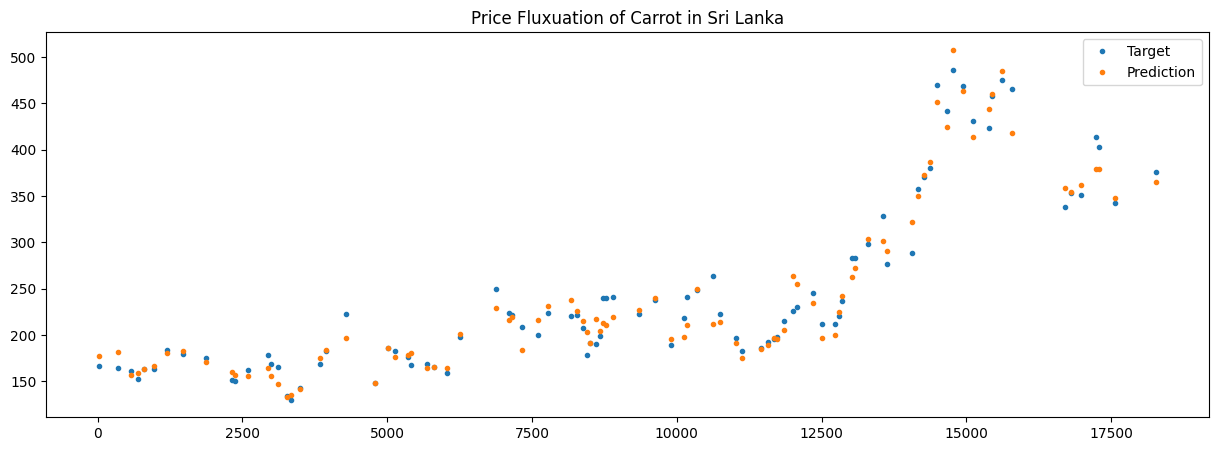

In [95]:
test2 = test.copy()
test2["prediction"] = regression_model.predict(X_test)
df2 = test2.copy()
ax = df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["Price"].plot(style=".", figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")
df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["prediction"].plot(ax=ax, style=".")
ax.legend(["Target", "Prediction"])

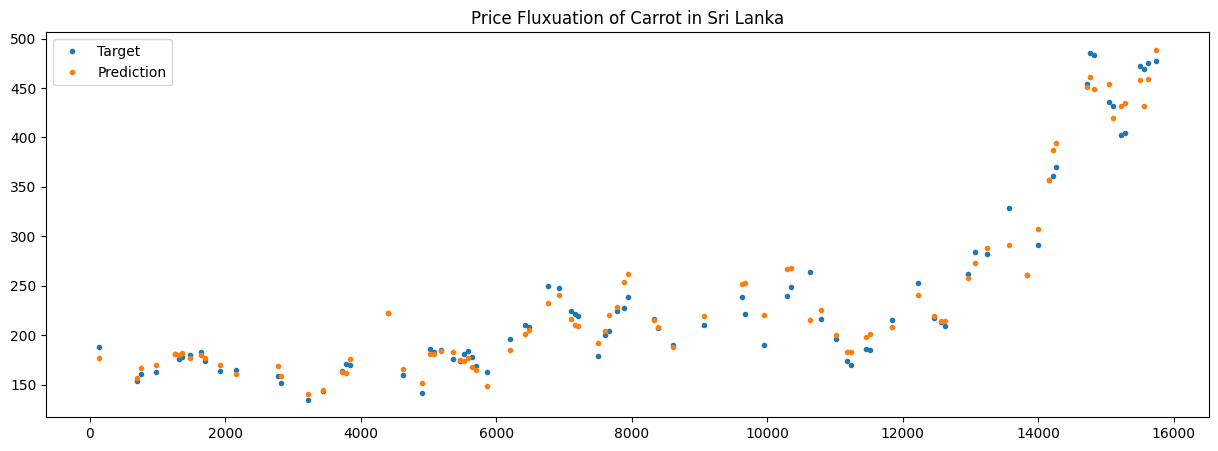

In [76]:
test2 = test.copy()
test2["prediction"] = regression_model.predict(X_test)
df2 = test2.copy()
ax = df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["Price"].plot(style=".", figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")
df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["prediction"].plot(ax=ax, style=".")
ax.legend(["Target", "Prediction"])

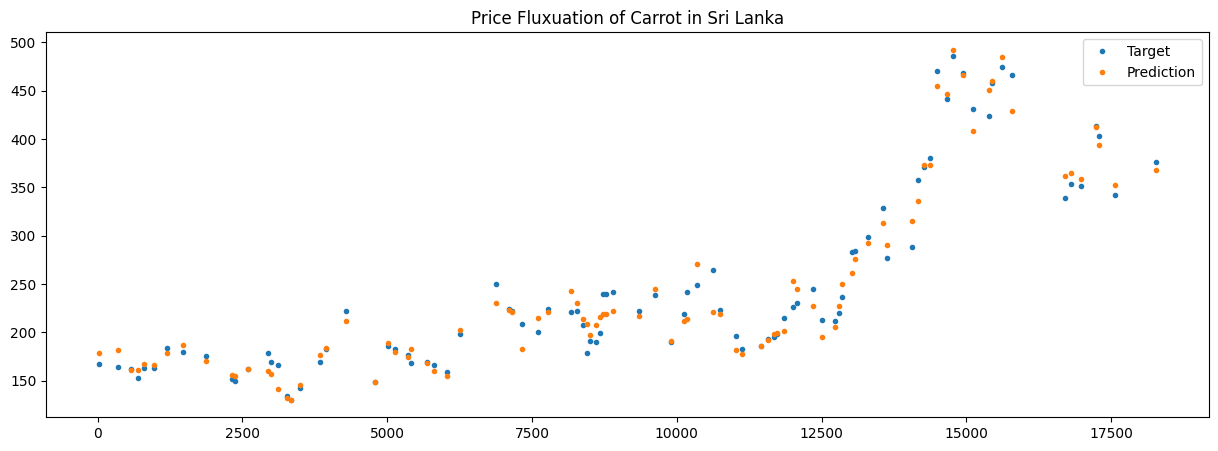

In [104]:
test2 = test.copy()
test2["prediction"] = regression_model.predict(X_test)
df2 = test2.copy()
ax = df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["Price"].plot(style=".", figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")
df2[df2["Name"] == "Potatoes_Local_POTATOES_1Kg"]["prediction"].plot(ax=ax, style=".")
ax.legend(["Target", "Prediction"])